In [1]:
using Yao, YaoPlots
using BitBasis
using CSV, DataFrames
using LinearAlgebra

In [2]:
function OracleFunc(b::DitStr)
    ndata = length(b)
    nqubit = 2 * ndata

    copydata = chain(
        nqubit,
        control(i, i+ndata=>X)
        for i in 1:ndata
    )

    # get locations of 1 in b
    idxnonzero = BitBasis.baddrs(b)
    firstnonzero = idxnonzero[1]

    if length(idxnonzero) == 0
        # b is all 0
        Uf = copydata

    else
        # at least one bit of b is 1
        # idx = idxnonzero[1]
        Uf = chain(
            nqubit,
            copydata,
            chain(
                nqubit,
                control(firstnonzero, i+ndata=>X)
                for i in idxnonzero
            )
        )
    end

    return Uf
end

function SimonAlgoCircuit(Uf::ChainBlock, ndata::Int)
    nqubit = 2 * ndata

    chain(
        nqubit,
        repeat(H, 1:ndata),
        put(1:nqubit=>Uf),
        repeat(H, 1:ndata)
    )
end

function Simulate(b::BitStr, nshots::Int=1024)
    ndata = length(b)
    nqubit = 2 * ndata
    Uf = OracleFunc(b)
    Circuit = SimonAlgoCircuit(Uf, ndata)
    initial_state = zero_state(nqubit)
    Meas(r) = measure(r, 1:ndata, nshots=nshots)

    output = initial_state |> Circuit |> Meas

    return (Circuit, output)
end

Simulate (generic function with 2 methods)

In [4]:
function savematrix(mat, filename::String="matrix.csv")
    mat = unique(mat)

    print(mat)
    
    nrow = length(mat)
    ncol = length(mat[1])

    open(filename, "w") do io
        for i in 1:nrow
            for j in ncol:-1:1
                s = string(mat[i][j]) * " "
                write(io, s)
            end
            write(io, "\n")
        end
    end
end

function loadvector(ndata::Int, filename::String="vector-b.csv")
    intb = 0
    
    df = DataFrame(
        CSV.File(
            "vector-b.csv",
            header=false,
            types=Int
        )
    )

    if nrow(df) == 0
        # the kernel is 0, thus b is 0
        bitb = BitStr{ndata, Int}(0)

        return bitb
    else
        b = Array(df[1, :])
        # nqubit = length(b)
        intb = sum([
            b[end-i] * 2^i
            for i in 0:ndata-1
        ])

        bitb = BitStr{ndata, Int}(intb)
    end

    return bitb
end

loadvector (generic function with 2 methods)

In [6]:
ndata = 6

s = rand(0 : (2^ndata - 1))

# secreteb = bit"110"
secreteb = BitStr{ndata, Int8}(s)
# ndata = length(secreteb)
# Uf = OracleFunc(secreteb)

101001 ₍₂₎

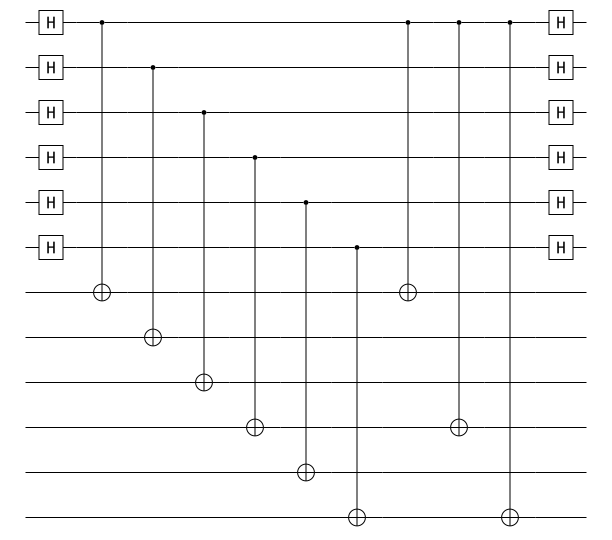

In [7]:
Circuit, output = Simulate(secreteb, 4*ndata)
plot(Circuit)

In [8]:
output

24-element Vector{DitStr{2, 6, Int64}}:
 011101 ₍₂₎
 111000 ₍₂₎
 010110 ₍₂₎
 001001 ₍₂₎
 100101 ₍₂₎
 010000 ₍₂₎
 111000 ₍₂₎
 111000 ₍₂₎
 100101 ₍₂₎
 000110 ₍₂₎
 110001 ₍₂₎
 101010 ₍₂₎
 110011 ₍₂₎
 010110 ₍₂₎
 101110 ₍₂₎
 101010 ₍₂₎
 010110 ₍₂₎
 010000 ₍₂₎
 011011 ₍₂₎
 011111 ₍₂₎
 101000 ₍₂₎
 100001 ₍₂₎
 111110 ₍₂₎
 100111 ₍₂₎

In [9]:
unique(output)

17-element Vector{DitStr{2, 6, Int64}}:
 011101 ₍₂₎
 111000 ₍₂₎
 010110 ₍₂₎
 001001 ₍₂₎
 100101 ₍₂₎
 010000 ₍₂₎
 000110 ₍₂₎
 110001 ₍₂₎
 101010 ₍₂₎
 110011 ₍₂₎
 101110 ₍₂₎
 011011 ₍₂₎
 011111 ₍₂₎
 101000 ₍₂₎
 100001 ₍₂₎
 111110 ₍₂₎
 100111 ₍₂₎

In [10]:
savematrix(output)

DitStr{2, 6, Int64}[011101 ₍₂₎, 111000 ₍₂₎, 010110 ₍₂₎, 001001 ₍₂₎, 100101 ₍₂₎, 010000 ₍₂₎, 000110 ₍₂₎, 110001 ₍₂₎, 101010 ₍₂₎, 110011 ₍₂₎, 101110 ₍₂₎, 011011 ₍₂₎, 011111 ₍₂₎, 101000 ₍₂₎, 100001 ₍₂₎, 111110 ₍₂₎, 100111 ₍₂₎]

In [11]:
solveeqs = `sage kernel-solver.sage`
run(solveeqs)

The following result saved to vector-b.csv.
Vector space of degree 6 and dimension 1 over Finite Field of size 2
Basis matrix:
[1 0 1 0 0 1]


Process(`sage kernel-solver.sage`, ProcessExited(0))

In [12]:
b = loadvector(ndata)

101001 ₍₂₎

In [13]:
b == secreteb

true

In [14]:
secreteb

101001 ₍₂₎